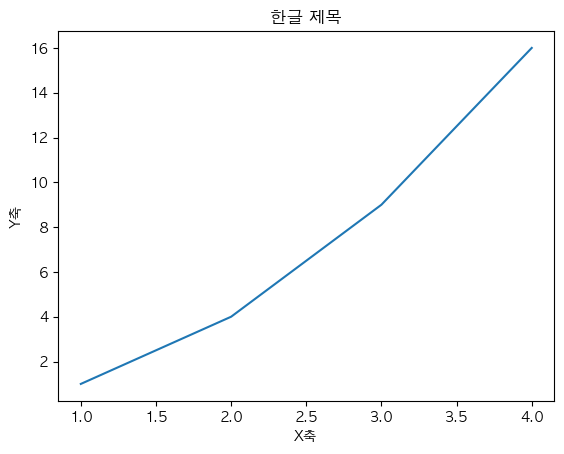

In [8]:
import matplotlib.pyplot as plt
from matplotlib import rc

# 한글 폰트 설정
rc('font', family='AppleGothic')

# 그래프에서 마이너스 폰트 깨지는 문제 해결
plt.rcParams['axes.unicode_minus'] = False

# 테스트용 그래프 그리기
plt.plot([1, 2, 3, 4], [1, 4, 9, 16])
plt.title('한글 제목')
plt.xlabel('X축')
plt.ylabel('Y축')
plt.show()

In [2]:
import pandas as pd

df = pd.read_csv('교통사고 데이터/전국교통사고다발지역표준데이터.csv', encoding='euc-kr')
drop_list = ['데이터기준일자', '제공기관코드', '제공기관명']
df = df.drop(columns=drop_list)
df.head()

,사고지역관리번호,사고연도,사고유형구분,위치코드,사고다발지역시도시군구,사고지역위치명,사고건수,사상자수,사망자수,중상자수,경상자수,부상신고자수,위도,경도,사고다발지역폴리곤정보
0,2013098,2012,보행노인,11470001,서울특별시 양천구1,서울특별시 양천구 신월동(대흥빌딩 부근),3,3,0,1,2,0,37.520654,126.834865,"{type:Polygon,coordinates:[[[126.8364647,37.52..."
1,2013098,2012,보행노인,11470002,서울특별시 양천구2,서울특별시 양천구 신정동(신정3평화은행 부근),3,4,1,2,1,0,37.517352,126.853553,"{type:Polygon,coordinates:[[[126.8551532,37.51..."
2,2013098,2012,보행노인,11500001,서울특별시 강서구1,서울특별시 강서구 화곡동(홍익병원앞_등촌로_진입_1 부근),3,3,0,1,2,0,37.530665,126.863875,"{type:Polygon,coordinates:[[[126.8654752,37.53..."
3,2013098,2012,보행노인,11500002,서울특별시 강서구2,서울특별시 강서구 화곡동(강서구청입구 부근),3,3,0,2,1,0,37.556113,126.852410,"{type:Polygon,coordinates:[[[126.8540101,37.55..."
4,2013098,2012,보행노인,11500003,서울특별시 강서구3,서울특별시 강서구 화곡동(화곡사거리 부근),4,4,0,2,2,0,37.530715,126.847285,"{type:Polygon,coordinates:[[[126.848885,37.531..."


In [33]:
df.columns

Index(['사고지역관리번호', '사고연도', '사고유형구분', '위치코드', '사고다발지역시도시군구', '사고지역위치명', '사고건수',
       '사상자수', '사망자수', '중상자수', '경상자수', '부상신고자수', '위도', '경도', '사고다발지역폴리곤정보'],
      dtype='object')

In [40]:
import json
import re

# JSON 전처리 함수
def preprocess_polygon_string(polygon_str):
    # 속성명을 이중 따옴표로 감싸기
    polygon_str = re.sub(r'(\w+):', r'"\1":', polygon_str)
    # 문자열 값인 Polygon과 같은 텍스트를 이중 따옴표로 감싸기
    polygon_str = re.sub(r'(?<=:)"?(\w+)"?(?=,|\})', r'"\1"', polygon_str)
    return polygon_str

# '사고다발지역폴리곤정보' 칼럼을 전처리하여 JSON으로 변환
df['사고다발지역폴리곤정보'] = df['사고다발지역폴리곤정보'].apply(preprocess_polygon_string)

# 변환된 데이터 확인
print(df['사고다발지역폴리곤정보'].head())

0    {"type":"Polygon","coordinates":[[[126.8364647...
1    {"type":"Polygon","coordinates":[[[126.8551532...
2    {"type":"Polygon","coordinates":[[[126.8654752...
3    {"type":"Polygon","coordinates":[[[126.8540101...
4    {"type":"Polygon","coordinates":[[[126.848885,...
Name: 사고다발지역폴리곤정보, dtype: object


In [43]:
import json

# GeoJSON 구조 생성
geojson_features = []

for index, row in df.iterrows():
    try:
        # 디버깅을 위해 문자열을 출력합니다.
        print(f"Processing row {index}: {row['사고다발지역폴리곤정보'][:100]}...")  # 길이가 길다면 앞부분만 출력
        
        # JSON 문자열을 파싱합니다.
        coordinates = json.loads(row['사고다발지역폴리곤정보'])['coordinates']
        
        feature = {
            "type": "Feature",
            "geometry": {
                "type": "Polygon",
                "coordinates": coordinates
            },
            "properties": {
                "사고건수": row["사고건수"],
                "사고지역": row["사고지역위치명"]
            }
        }
        geojson_features.append(feature)
    
    except json.JSONDecodeError as e:
        print(f"JSONDecodeError at row {index}: {e}")
        print(f"Problematic string: {row['사고다발지역폴리곤정보']}")
        break

geojson_data = {
    "type": "FeatureCollection",
    "features": geojson_features
}

# GeoJSON 파일로 저장
with open('accidents_geojson_data.geojson', 'w', encoding='utf-8') as f:
    json.dump(geojson_data, f, ensure_ascii=False, indent=4)

print("GeoJSON 파일이 성공적으로 저장되었습니다.")


Processing row 0: {"type":"Polygon","coordinates":[[[126.8364647,37.5219279],[126.8361218,37.522152],[126.8357307,37.5...
Processing row 1: {"type":"Polygon","coordinates":[[[126.8551532,37.5186266],[126.8548103,37.5188507],[126.8544192,37....
Processing row 2: {"type":"Polygon","coordinates":[[[126.8654752,37.5319393],[126.8651323,37.5321634],[126.8647411,37....
Processing row 3: {"type":"Polygon","coordinates":[[[126.8540101,37.5573867],[126.8536671,37.5576108],[126.8532757,37....
Processing row 4: {"type":"Polygon","coordinates":[[[126.848885,37.5319893],[126.8485421,37.5322134],[126.8481509,37.5...
Processing row 5: {"type":"Polygon","coordinates":[[[126.877647,37.5482423],[126.8773041,37.5484664],[126.8769128,37.5...
Processing row 6: {"type":"Polygon","coordinates":[[[126.8363139,37.549411],[126.835971,37.5496351],[126.8355797,37.54...
Processing row 7: {"type":"Polygon","coordinates":[[[126.9336485,37.613848],[126.9333052,37.6140721],[126.9329136,37.6...
Processing row 8: {"type

In [6]:
# 사고건수가 최대인 행을 필터링하여 해당 사고지역위치명과 사고건수를 가져옵니다.
max_accident_info = df.loc[df['사고건수'] == df['사고건수'].max(), ['사고지역위치명', '사고건수']]

# 결과 출력
print(max_accident_info)

                    사고지역위치명  사고건수
3040  서울특별시 관악구 신림동(신림역 부근)    27


In [2]:
import pandas as pd

df2 = pd.read_csv('교통사고 데이터/도로교통공단_일자별 시군구별 교통사고 건수(2019).csv', encoding='euc-kr')
df2.head()

,발생월,발생일,시도,시군구,사고건수,사망자수,중상자수,경상자수,부상신고자수
0,1,1,서울,종로구,1,0,1,0,0
1,1,1,서울,중구,1,0,0,1,0
2,1,1,서울,용산구,2,0,1,1,0
3,1,1,서울,성동구,1,0,0,1,0
4,1,1,서울,동대문구,2,0,0,2,0


In [22]:
import pandas as pd

df2 = pd.read_csv('교통사고 데이터/도로교통공단_일자별 시군구별 교통사고 건수(2020).csv', encoding='euc-kr')
df2.head()

,발생월,발생일,시도,시군구,사고건수,사망자수,중상자수,경상자수,부상신고자수
0,1,1,서울,종로구,1,0,0,1,0
1,1,1,서울,중구,1,0,0,2,0
2,1,1,서울,용산구,2,0,0,5,0
3,1,1,서울,성동구,1,0,0,1,0
4,1,1,서울,동대문구,3,0,1,2,0


In [10]:
import json
import folium
from folium.plugins import HeatMap
import pandas as pd
import branca.colormap as cm
from matplotlib import rc
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# 한글 폰트 설정
rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# ----------------------------
# 데이터 불러오기 및 전처리
# ----------------------------

# 교통사고 다발 지역 데이터 불러오기
df = pd.read_csv('교통사고 데이터/전국교통사고다발지역표준데이터.csv', encoding='euc-kr')
drop_list = ['데이터기준일자', '제공기관코드', '제공기관명']
df = df.drop(columns=drop_list)

# GeoJSON 파일 불러오기
with open('법정구역 GeoJSON 데이터_23년8월/법정구역_시군구.geojson', encoding='utf-8') as f:
    geojson_data = json.load(f)

# 사고건수 기준으로 데이터 내림차순 정렬
df_sorted = df.sort_values(by='사고건수', ascending=False)

# 사고 지역 코드와 GeoJSON의 ID가 일치하도록 데이터프레임을 정리
df['위치코드'] = df['위치코드'].astype(str)

df

,사고지역관리번호,사고연도,사고유형구분,위치코드,사고다발지역시도시군구,사고지역위치명,사고건수,사상자수,사망자수,중상자수,경상자수,부상신고자수,위도,경도,사고다발지역폴리곤정보
0,2013098,2012,보행노인,11470001,서울특별시 양천구1,서울특별시 양천구 신월동(대흥빌딩 부근),3,3,0,1,2,0,37.520654,126.834865,"{type:Polygon,coordinates:[[[126.8364647,37.52..."
1,2013098,2012,보행노인,11470002,서울특별시 양천구2,서울특별시 양천구 신정동(신정3평화은행 부근),3,4,1,2,1,0,37.517352,126.853553,"{type:Polygon,coordinates:[[[126.8551532,37.51..."
2,2013098,2012,보행노인,11500001,서울특별시 강서구1,서울특별시 강서구 화곡동(홍익병원앞_등촌로_진입_1 부근),3,3,0,1,2,0,37.530665,126.863875,"{type:Polygon,coordinates:[[[126.8654752,37.53..."
3,2013098,2012,보행노인,11500002,서울특별시 강서구2,서울특별시 강서구 화곡동(강서구청입구 부근),3,3,0,2,1,0,37.556113,126.852410,"{type:Polygon,coordinates:[[[126.8540101,37.55..."
4,2013098,2012,보행노인,11500003,서울특별시 강서구3,서울특별시 강서구 화곡동(화곡사거리 부근),4,4,0,2,2,0,37.530715,126.847285,"{type:Polygon,coordinates:[[[126.848885,37.531..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13358,2022084,2021,보행어린이,45140001,전라북도 익산시1,전라북도 익산시 영등동(천일빌라 부근),3,3,0,0,3,0,35.954539,126.973641,"{type:Polygon,coordinates:[[[126.97543771,35.9..."
13359,2022084,2021,보행어린이,46110001,전라남도 목포시1,전라남도 목포시 용해동(목포용해초교 부근),3,3,0,1,2,0,34.817988,126.397695,"{type:Polygon,coordinates:[[[126.39949123,34.8..."
13360,2022084,2021,보행어린이,46110002,전라남도 목포시2,전라남도 목포시 산정동(목포주안교회 부근),3,3,0,0,3,0,34.805209,126.374488,"{type:Polygon,coordinates:[[[126.37628414,34.8..."
13361,2022084,2021,보행어린이,47130001,경상북도 경주시1,경상북도 경주시 용강동(황성초교 부근),4,4,0,1,3,0,35.859953,129.224346,"{type:Polygon,coordinates:[[[129.22614311,35.8..."


In [11]:
def make_choropleth(input_df, geojson, input_id, input_column, input_color_theme):
    choropleth = px.choropleth(input_df, 
                               geojson=geojson, 
                               locations=input_id, 
                               color=input_column,
                               featureidkey="properties.SIG_CD",  # GeoJSON의 ID와 맞추기
                               color_continuous_scale=input_color_theme,
                               scope="asia",  # 위치 범위를 설정 (필요시 조정)
                               labels={input_column: input_column})
    
    choropleth.update_geos(fitbounds="locations", visible=False)
    choropleth.update_layout(
        template='plotly_dark',
        plot_bgcolor='rgba(0, 0, 0, 0)',
        paper_bgcolor='rgba(0, 0, 0, 0)',
        margin=dict(l=0, r=0, t=0, b=0),
        height=600
    )
    return choropleth

In [ ]:
# Choropleth 맵 표시
choropleth_map = make_choropleth(df, geojson_data, '위치코드', '사고건수', 'Viridis')
plotly_chart(choropleth_map)